# Code optimization in Python

In [1]:
from platform import python_version
python_version()

'3.7.1'

In [2]:
import numpy as np
import pandas as pd
from importlib import reload
from scipy import ndimage
from numba import jit

import matplotlib.pyplot as plt

## Raw Python

In [3]:
# Sub-routines to calculate mandelbrot set

def mandelbrot(z, maxiter):
    c = z
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return maxiter

def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, maxiter):

    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)

    return (r1, r2, [mandelbrot(complex(r, i), maxiter)
                     for r in r1 for i in r2])

In [4]:
# Evaluate n for one point
x, y = 0.6, 0.35
mandelbrot(complex(x, y), 100)

3

In [5]:
r1, r2, data = mandelbrot_set(-2.0, 0.5, -1.0, 1.0, 250, 200, 100)

In [6]:
type(r1), type(r2), type(data)

(numpy.ndarray, numpy.ndarray, list)

In [7]:
img = np.array(data).reshape(len(r1), len(r2))
img.shape

(250, 200)

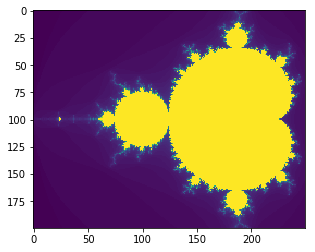

In [8]:
plt.imshow(ndimage.interpolation.rotate(img, 90))
plt.show()

In [9]:
%timeit r1, r2, data = mandelbrot_set(-2.0, 0.5, -1.0, 1.0, 250, 200, 100)

336 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


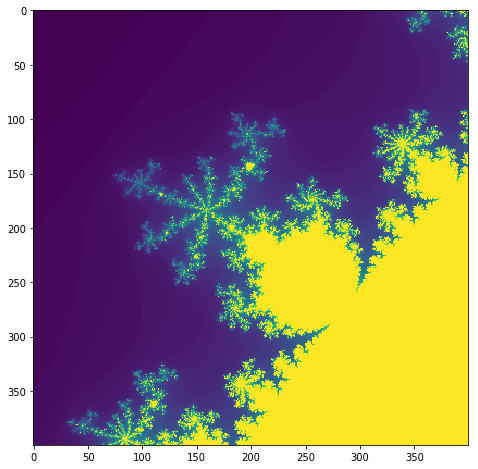

In [10]:
r1, r2, data = mandelbrot_set(-0.75, -0.55, 0.35, 0.55, 400, 400, 100)
img = np.array(data).reshape(len(r1), len(r2))
plt.figure(figsize=(8,8))
plt.imshow(ndimage.interpolation.rotate(img, 90))
plt.show()

In [11]:
del mandelbrot, mandelbrot_set

## Numba

In [12]:
# Sub-routines to calculate mandelbrot set

@jit
def mandelbrot_jit(z, maxiter):
    c = z
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return maxiter

def mandelbrot_set_jit(xmin, xmax, ymin, ymax, width, height, maxiter):

    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)

    return (r1, r2, [mandelbrot_jit(complex(r, i), maxiter)
                     for r in r1 for i in r2])

In [13]:
%timeit r1, r2, data = mandelbrot_set_jit(-2.0, 0.5, -1.0, 1.0, 250, 200, 100)

33.1 ms ± 870 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
# Speed improvement:
428/39

10.974358974358974

In [15]:
# Sub-routines to calculate mandelbrot set

@jit
def mandelbrot_jit(z, maxiter):
    c = z
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return maxiter

@jit
def mandelbrot_set_jit(xmin, xmax, ymin, ymax, width, height, maxiter):

    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)

    return (r1, r2, [mandelbrot_jit(complex(r, i), maxiter)
                     for r in r1 for i in r2])

In [16]:
%timeit r1, r2, data = mandelbrot_set_jit(-2.0, 0.5, -1.0, 1.0, 250, 200, 100)

11.3 ms ± 98 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# Speed improvement:
428/12.4

34.516129032258064

In [18]:
@jit
def mandelbrot_jit(creal,cimag,maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal       
    return 0


@jit
def mandelbrot_set_jit(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot_jit(r1[i],r2[j],maxiter)
    return (r1,r2,n3)

In [19]:
%timeit r1, r2, data = mandelbrot_set_jit(-2.0, 0.5, -1.0, 1.0, 250, 200, 100)

6.97 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Cython

In [26]:
%%writefile mandelbrot_cy.pyx
"""Sub-routines to calculate mandelbrot set
"""
import cython
import numpy as np

cdef int mandelbrot(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2*real*imag + cimag
        real = real2 - imag2 + creal;
    return 0

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef mandelbrot_set(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter):
    cdef:
        double[:] r1 = np.linspace(xmin, xmax, width)
        double[:] r2 = np.linspace(ymin, ymax, height)
        int[:,:] n3 = np.empty((width,height), np.int)
        int i, j
    
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i], r2[j], maxiter)
     
    return (r1, r2, n3)

Overwriting mandelbrot_cy.pyx


In [27]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("mandelbrot_cy.pyx")
)

Overwriting setup.py


In [28]:
!python setup.py build_ext --inplace

Compiling mandelbrot_cy.pyx because it changed.
[1/1] Cythonizing mandelbrot_cy.pyx
/Users/billtubbs/anaconda/envs/py37/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/billtubbs/cython-examples/mandelbrot_cy.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'mandelbrot_cy' extension
clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -mmacosx-version-min=10.9 -m64 -fPIC -Wl,-export_dynamic -g -mmacosx-version-min=10.9 -m64 -fPIC -I/Users/billtubbs/anaconda/envs/py37/include/python3.7m -c mandelbrot_cy.c -o build/temp.macosx-10.9-x86_64-3.7/mandelbrot_cy.o
clang-6.0: warning: -Wl,-export_dynamic: 'linker' input unused [-Wunused-command-line-argument]
clang -bundle -undefined dynamic_lookup -headerpad_max_install_names -mmacosx-version-min=10.9 -lc++ -Wl,-rpath,/Users/billtubbs/anac

In [29]:
import mandelbrot_cy

In [31]:
%timeit r1, r2, data = mandelbrot_cy.mandelbrot_set(-2.0, 0.5, -1.0, 1.0, 250, 200, 100)

6.56 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


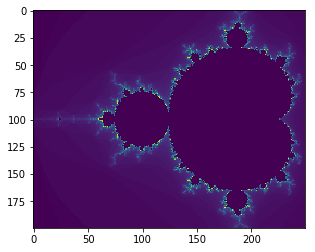

In [32]:
img = np.array(data).reshape(len(r1), len(r2))
plt.imshow(ndimage.interpolation.rotate(img, 90))
plt.show()